In [19]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import numpy.random as rd
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import silhouette_score
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from scipy.stats import lognorm
from util import centroid_label, aggp_label, coordinator_label, worker_label, ccolor, cmarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df_atlas = pd.read_csv("datasets/RIPEAtlas/19062023/RIPEAtlas_coords.csv", sep=",", header=None, names=["x", "y"])
df_atlas["type"] = "worker"
tcolors = {"coordinator": "red", "worker": "grey"}
eval_matrix = {}
X_dim = [-200, 300]
Y_dim = [-250, 400]

In [ ]:
df_atlas.head()

,x,y,type
0,-93.917515,202.161843,worker
1,-133.101399,-123.417988,worker
2,77.039491,-208.571409,worker
3,-185.479238,102.680454,worker
4,-159.584229,-110.718603,worker


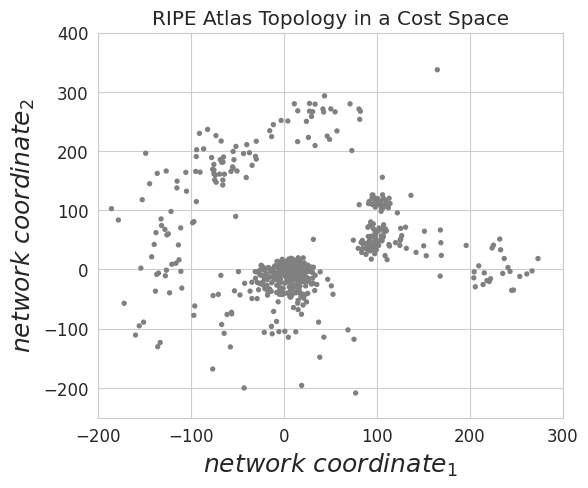

In [ ]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

scat2 = df_atlas.plot.scatter(ax=ax1, x="x", y="y", c=df_atlas["type"].map(tcolors), s=8)

#plot coordinators
#ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

#ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/atlas/atlas_ncs.svg", bbox_inches = "tight")

ax1.set_title('RIPE Atlas Topology in a Cost Space')
plt.show()

In [ ]:
coords = df_atlas[["x", "y"]].to_numpy()

## Atlas

10
15
20
25
30
[0.6636217496244058, 0.5136072629540194, 0.5077206196111971, 0.5061110863666999, 0.5070548436509719, 0.4253839034689318, 0.4041053890939097, 0.3961310410727553, 0.3951408135242146, 0.39317297313886734, 0.39664871012821096, 0.38656005894973516, 0.39218843800173725, 0.3943922268049132, 0.39077032076021967, 0.3714343051990196, 0.37135061105407885, 0.37298783604008434, 0.37388268583163026, 0.377634701753794, 0.3804582058837204, 0.36617681732360075]
Optimal k is  9


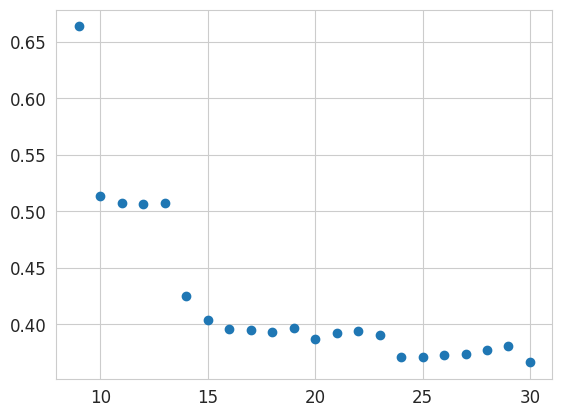

In [ ]:
sil = []
kmin = 9  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

opt_k = np.argmax(sil)
opt_k = kmin + opt_k
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)

In [ ]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 9
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

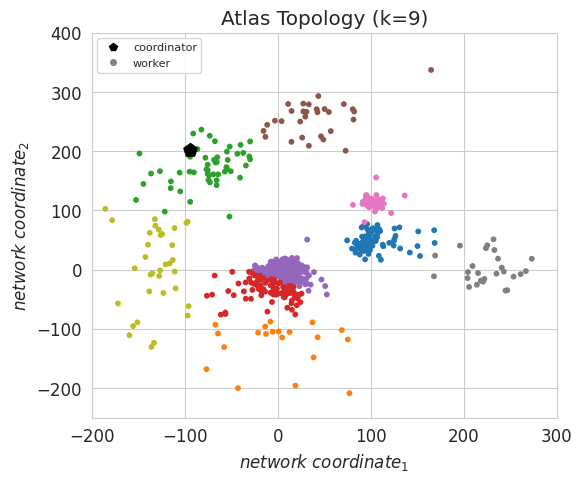

In [ ]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
#super_plot.scatter(centroids[:, 0], centroids[:, 1], s=100, marker="o", color=colors)
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/atlas/atlas_" + str(no_clusters) + ".svg", bbox_inches = "tight")
plt.title('Atlas Topology (k=' + str(no_clusters) + ")")
plt.show()

## Capacity Config

Std:  50.482103512036815


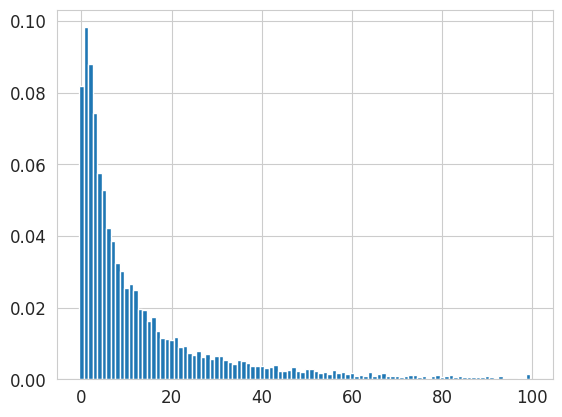

In [24]:
mode = 1
stddev = 50
sigma, scale = util.lognorm_params(mode, stddev)
sample = lognorm.rvs(sigma, 0, scale, size=10000).astype(int)

print("Std: ", np.std(sample))

H, bins = np.histogram(sample, bins=100, range=[0, 100], density=True)
plt.bar(bins[:-1],H,width=1)
plt.show()

In [26]:
capacity_columns = []
np.random.seed(4)
avg = 50
c_coords = coords[0]
device_number = len(df_atlas)
max_resources = device_number*avg - 100
type_list = ["worker" for x in range(device_number - 1)]
type_list.insert(0, "coordinator")

df = pd.DataFrame(coords, columns=["x", "y"])
df['latency'] = list(zip(df.x, df.y))
df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
df["type"] = pd.Series(type_list, dtype="category")
df["cluster"] = labels
df.loc[0, "cluster"] = -1

sums = []
for i in range(len(H), 0, -1):
    if (i % 10 == 0) or (i == 5) or (i == 1):
        #probabilites
        p = np.array(H[i-1:len(H)])
        p /= p.sum()  # normalize
        pop = np.arange(i-1, len(H))

        capacity_list = np.random.choice(pop, len(df)-1, p=p, replace=True)
        capacity_list =np.insert(capacity_list, 0, 0)

        col = "capacity_"+str(i)
        df[col] = pd.Series(capacity_list, dtype="int")
        df["capacity_"+str(i)] = df[col] / df[col].sum() * max_resources

        df[col] = np.ceil(df[col]).astype("int")
        df.at[0, col] = 100
        sums.append((df[col].sum()))
        capacity_columns.append(col)

print(sums)
prim_df = df.copy()

[36200, 36487, 36524, 36468, 36544, 36487, 36494, 36498, 36522, 36578, 36503, 36520]


In [28]:
prim_df

,x,y,latency,type,cluster,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,-93.917515,202.161843,0.000000,coordinator,-1,100,100,100,100,100,100,100,100,100,100,100,100
1,-133.101399,-123.417988,327.929265,worker,8,50,49,53,45,44,57,52,32,58,23,18,9
2,77.039491,-208.571409,444.891113,worker,1,50,53,57,51,53,47,40,51,59,17,16,70
3,-185.479238,102.680454,135.203905,worker,8,50,48,52,60,64,62,62,43,97,72,21,29
4,-159.584229,-110.718603,319.697186,worker,8,50,52,48,42,62,70,39,33,37,21,122,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,-36.457796,-36.644464,245.621806,worker,3,50,48,54,43,40,41,36,69,35,70,11,276
719,5.153206,17.416845,209.632349,worker,4,50,48,53,57,42,48,79,81,58,74,16,17
720,-11.880711,-3.653801,221.562895,worker,4,50,50,46,45,45,42,74,51,26,19,94,5
721,-25.491140,-9.502637,222.450041,worker,3,50,49,57,54,49,75,45,34,45,21,54,29


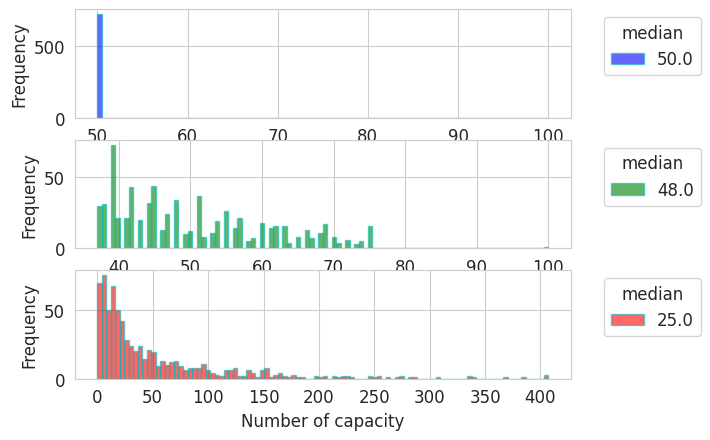

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

i=100
df["capacity_"+str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c', label=df["capacity_"+str(i)].median())

i=50
df["capacity_"+str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c', label=df["capacity_"+str(i)].median())

i=1
df["capacity_"+str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c', label=df["capacity_"+str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')

ax3.set_xlabel("Number of capacity")

plt.show()

Medians from  50  to  25


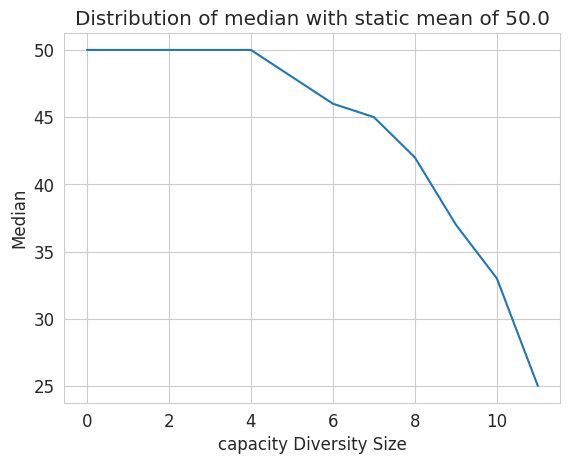

In [31]:
medians = []
mean = np.floor(prim_df["capacity_"+str(1)].mean())

for col in capacity_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("capacity Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator

In [32]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["dt"] = df_stats.copy()

### Experiment 2: LEACH Protocol

In [33]:
seed = 20
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(device_number*0.1)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  72
[703, 155, 267, 691, 651, 104, 336, 587, 174, 28, 422, 417, 77, 106, 129, 327, 486, 595, 461, 214, 205, 325, 641, 698, 344, 337, 438, 95, 643, 531, 504, 415, 84, 212, 249, 36, 207, 97, 86, 195, 260, 711, 291, 313, 707, 263, 168, 639, 121, 24, 274, 240, 225, 588, 244, 58, 14, 661, 633, 308, 287, 141, 712, 663, 615, 459, 157, 654, 281, 570, 444, 161]


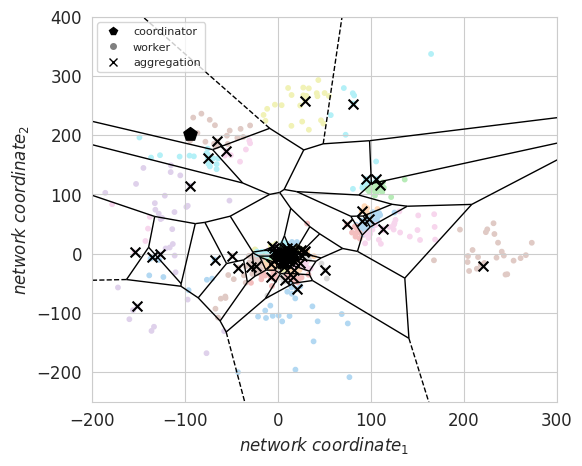

In [34]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, aggp_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/atlas/leach.svg")
plt.show()

In [35]:
statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["leach"] = df_stats.copy()

### Experiment 3a: NEMO Aggregation with Density-based Grouping

In [36]:
prim_df

,x,y,latency,type,cluster,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,-93.917515,202.161843,0.000000,coordinator,-1,100,100,100,100,100,100,100,100,100,100,100,100
1,-133.101399,-123.417988,327.929265,worker,8,50,49,53,45,44,57,52,32,58,23,18,9
2,77.039491,-208.571409,444.891113,worker,1,50,53,57,51,53,47,40,51,59,17,16,70
3,-185.479238,102.680454,135.203905,worker,8,50,48,52,60,64,62,62,43,97,72,21,29
4,-159.584229,-110.718603,319.697186,worker,8,50,52,48,42,62,70,39,33,37,21,122,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,-36.457796,-36.644464,245.621806,worker,3,50,48,54,43,40,41,36,69,35,70,11,276
719,5.153206,17.416845,209.632349,worker,4,50,48,53,57,42,48,79,81,58,74,16,17
720,-11.880711,-3.653801,221.562895,worker,4,50,50,46,45,45,42,74,51,26,19,94,5
721,-25.491140,-9.502637,222.450041,worker,3,50,49,57,54,49,75,45,34,45,21,54,29


In [37]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

capacity_col = "capacity_100"
med_label = first_med_label
eval_name = "nemo_dc"
eval_matrix[eval_name], new_paths_flat, agg_dict_flat, df_dict_flat = evaluate_nemo(prim_df, coords, W, L, False, capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


In [38]:
reassigned_clussters = util.get_diff(agg_dict_flat["base"], agg_dict_flat[capacity_col])
print(reassigned_clussters)

[0, 2, 3, 4]


In [39]:
#Test to see if there are any overloaded nodes, result should be empty
df_overloaded = df_dict_flat[capacity_col].groupby(['parent']).size()
df_capacity = df_dict_flat[capacity_col][capacity_col][df_overloaded.index]
result = pd.concat([df_capacity, df_overloaded], axis=1).reindex(df_overloaded.index)
result.columns = ["capacity", "count"]
result["load"] = result["capacity"] - result["count"]
result[result["load"] < 0]

,capacity,count,load
parent,,,


In [40]:
centroids

array([[ 102.34229367,   46.46021072],
       [   0.38404527, -125.17129271],
       [ -76.65611415,  172.66346859],
       [  -8.39281521,  -34.444662  ],
       [   9.83729993,   -2.80708983],
       [  39.1026418 ,  255.21314678],
       [ 102.93639662,  113.34350275],
       [ 225.51329156,    0.98840896],
       [-131.05433263,    2.46710325]])

In [41]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

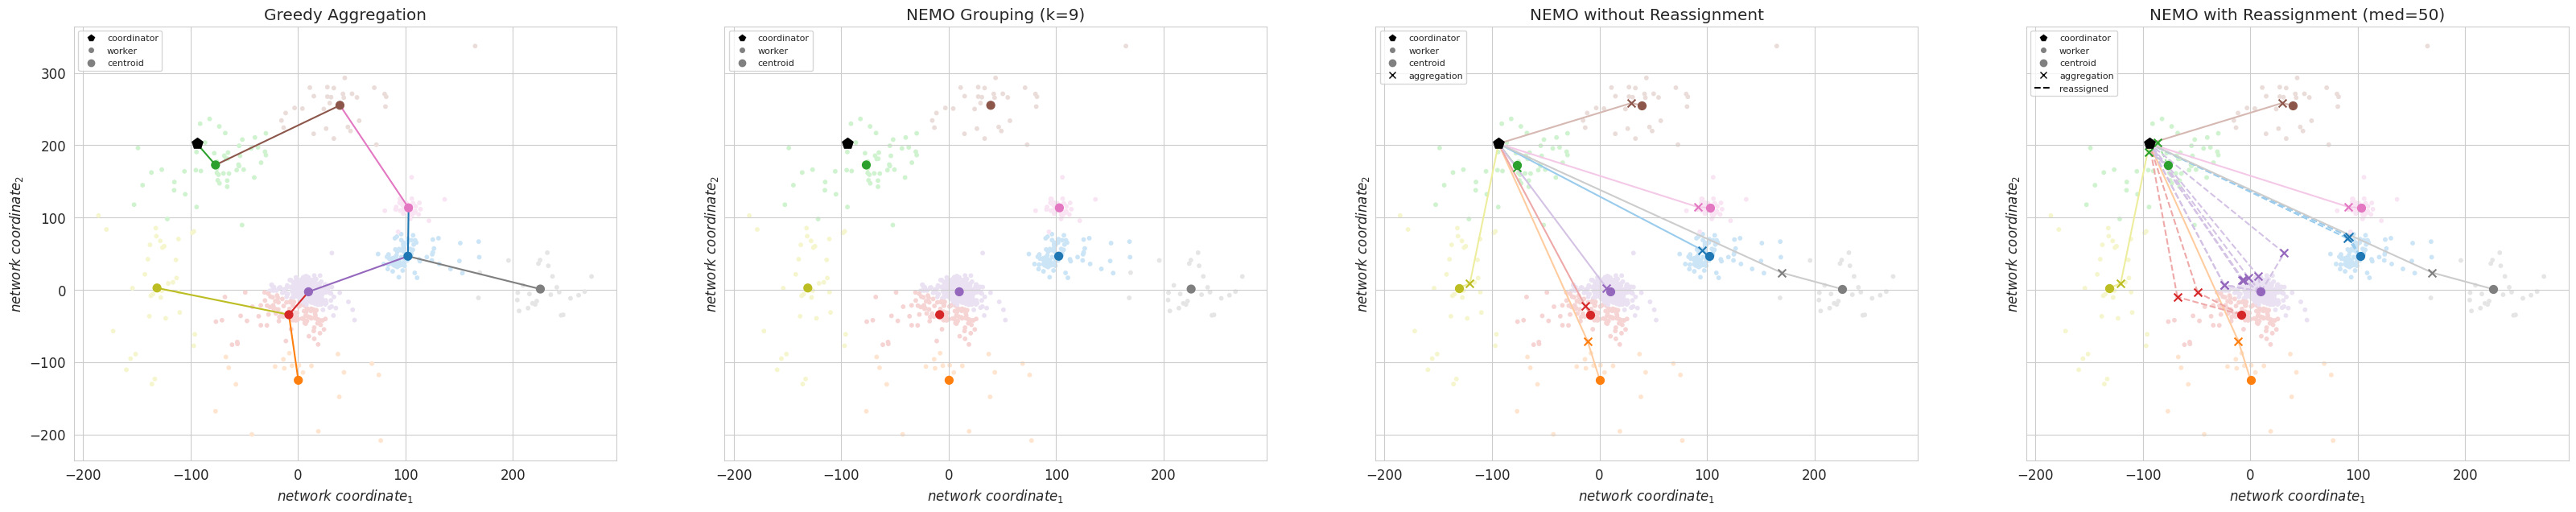

In [42]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i-1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax2.set_title('NEMO Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot(ax3, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels, lval=lval)
util.plot(ax4, new_paths_flat[capacity_col], agg_dict_flat[capacity_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("NEMO without Reassignment")
ax4.set_title("NEMO with Reassignment (med=" + med_label + ")")

plt.savefig("plots/atlas/nemo_phases_atlas.svg",  bbox_inches="tight")

# Save just the portion _inside_ the second axis's boundaries
names = ["greedy.svg", "nemo_grouping.svg", "nemo_plcmt.svg", "nemo_reassignment.svg"]
axes = [ax1, ax2, ax3, ax4]
#for i in range(0, 4):
#    extent = util.full_extent(axes[i]).transformed(fig.dpi_scale_trans.inverted())
#    fig.savefig("plots/atlas/" + names[i], bbox_inches="tight")

plt.show()

### Experiment 3b: NEMO Aggregation with Random Grouping

In [43]:
np.random.seed(10)
random_labels = np.random.randint(0, no_clusters, df.shape[0])
random_labels[0] = -1
iterations = 100
W = 80
L = 100
df = prim_df.copy()
df["cluster"] = random_labels

In [44]:
eval_name = "nemo_rc"
eval_matrix[eval_name], new_paths_rdm, agg_dict_rdm, df_dict_rdm = evaluate_nemo(df, coords, W, L, False,capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


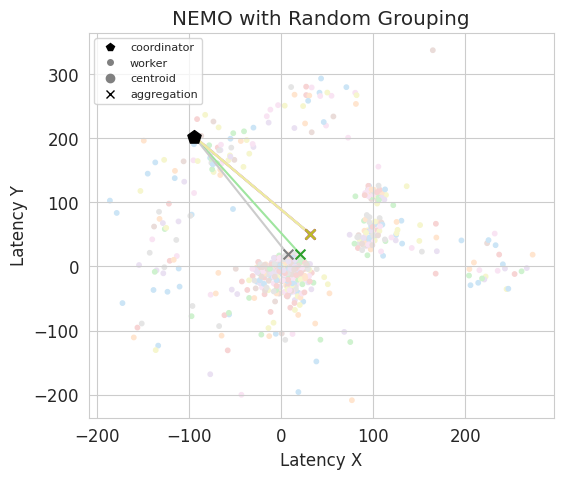

In [45]:
fig = plt.figure(figsize=(6, 5))
lval = 0.2

f1 = fig.add_subplot(111)
random_labels[0] = 0
util.plot(f1, new_paths_rdm["base"], agg_dict_rdm["base"], c_coords, None, coords, colors, random_labels, lval=lval,
          print_centroids=False)

plt.xlabel('Latency X')
plt.ylabel('Latency Y')
plt.title('NEMO with Random Grouping')

plt.show()

Distribution of workload:  0.5533 %


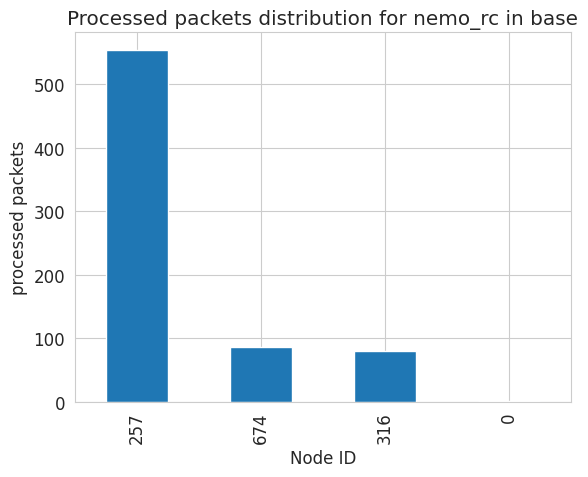

In [46]:
eval_col = list(eval_matrix[eval_name])[0]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [47]:
mst = prim_mst(coords)

In [48]:
print(mst)

[-1, 4, 340, 363, 338, 52, 17, 42, 364, 365, 59, 3, 38, 579, 119, 360, 8, 563, 366, 26, 117, 149, 458, 30, 16, 56, 82, 20, 83, 31, 6, 87, 105, 207, 116, 389, 496, 376, 361, 100, 44, 464, 5, 231, 505, 386, 703, 706, 275, 157, 398, 228, 62, 128, 0, 362, 15, 103, 19, 86, 140, 150, 87, 113, 347, 47, 661, 478, 315, 296, 322, 313, 374, 357, 312, 135, 312, 404, 109, 262, 380, 651, 0, 6, 41, 430, 361, 28, 671, 458, 174, 570, 554, 209, 654, 475, 352, 239, 352, 351, 471, 636, 516, 59, 519, 147, 438, 483, 125, 99, 268, 594, 139, 368, 688, 498, 576, 38, 219, 5, 471, 436, 662, 102, 37, 540, 164, 341, 469, 25, 15, 709, 597, 272, 10, 190, 129, 279, 668, 266, 388, 151, 37, 109, 500, 39, 116, 266, 468, 148, 375, 575, 226, 648, 309, 663, 98, 693, 538, 704, 306, 484, 592, 687, 144, 156, 247, 563, 213, 216, 237, 145, 627, 702, 318, 495, 611, 84, 405, 417, 412, 625, 395, 467, 69, 536, 76, 201, 212, 239, 655, 649, 326, 229, 676, 40, 177, 659, 524, 695, 243, 33, 250, 463, 716, 618, 481, 183, 666, 661, 608, 7

In [49]:
routes = createRoutes(mst)
print(routes[3])

[363, 429, 567, 130, 15, 360, 23, 30, 6, 17, 563, 19, 26, 82, 0]


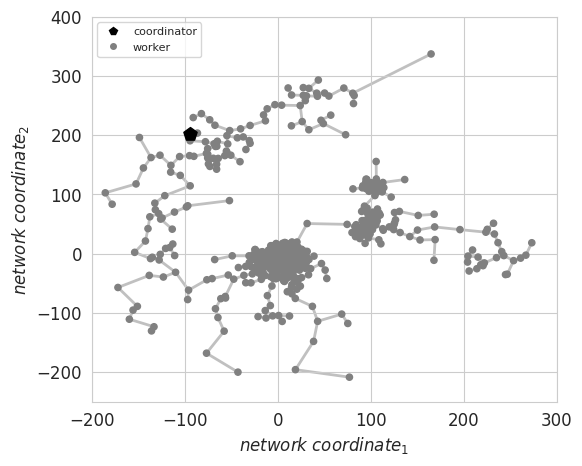

In [50]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/mst_atlas.svg", bbox_inches = "tight")
plt.show()

In [51]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["mst"] = df_stats.copy()

### Experiment 5: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [52]:
# the adjacency matrix for the plane
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:49839.0, valueBest:49839.0
i:10, t(i):3.49, valueNow:34940.0, valueBest:34940.0
i:20, t(i):1.22, valueNow:29791.0, valueBest:29789.0
i:30, t(i):0.42, valueNow:27036.0, valueBest:27036.0
i:40, t(i):0.15, valueNow:25532.0, valueBest:25532.0
i:50, t(i):0.05, valueNow:24069.0, valueBest:24069.0
i:60, t(i):0.02, valueNow:22876.0, valueBest:22876.0


In [53]:
print(route)

[162 432 493 719 114 168 323 688 502 397 462 259 612 326 234 328 586 407
 720 460 621 596 615 485 623 618 619 620 616 617 622 338 339 184 510 651
 647 349 482 665 235 707 657 411 227 555 215 177 181 609 233 495 431 137
 324 668 173 552 599 506 325 405  71 541 512 504 282 316 456 578  20 694
  86  38 453 141 139 607 198 395 104 474 486 205 671 648 417 672 305  94
 670 402 546 465 684  21  24 690 356 113  63 274 566 410 300 238 307 553
 221 721 518 334 624 538 581 613 652 709 710 317 413 127 204 716 400 222
 337 220 537 604 479 258 527 296 342   1 255 439 131  82   0  23 568  89
 362  16  55 359 219  19 491 361 365 488  31  28  56 567 130 509 470   6
 121 436 711 473 261 295  81 526 229 247 213 658 633  40 570 544 573 505
   5  42  17 563  54 560  22  57 458  91 545  35 389 454 638 643 678 655
 190 189 228 528 669  46 155  67 478 164  78  79 480  52  30  29 158 630
 588 414 416 461 172 601 308 521 712 193 225 210 508  99 165 498 355 380
 574 639 695 199 543 236 237 257 471 171 500 115  9

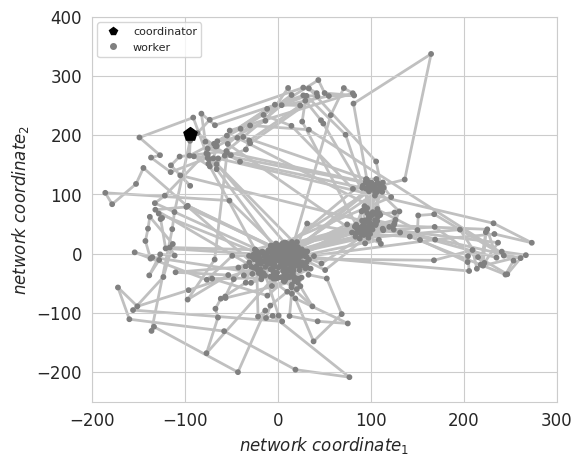

In [54]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/atlas/chain_50n.svg", bbox_inches = "tight")
plt.show()

In [55]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  140  in route.


In [56]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
718    1.0
719    1.0
720    1.0
721    1.0
722    1.0
Name: received_packets, Length: 723, dtype: float64


count      723.000000
mean      8520.425089
std       5229.682489
min          0.000000
25%       3790.502126
50%       8120.713549
75%      13020.352379
max      17749.609987
Name: latency_distribution, dtype: float64


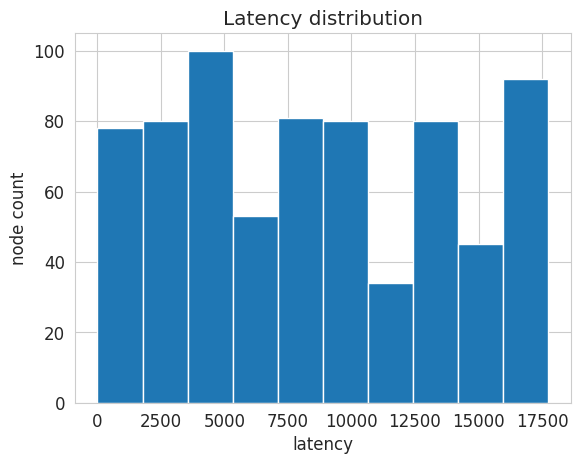

In [57]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count      723.000000
mean      8520.425089
std       5229.682489
min          0.000000
25%       3790.502126
50%       8120.713549
75%      13020.352379
max      17749.609987
Name: latency_distribution, dtype: float64
count    723.000000
mean       0.998617
std        0.064445
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


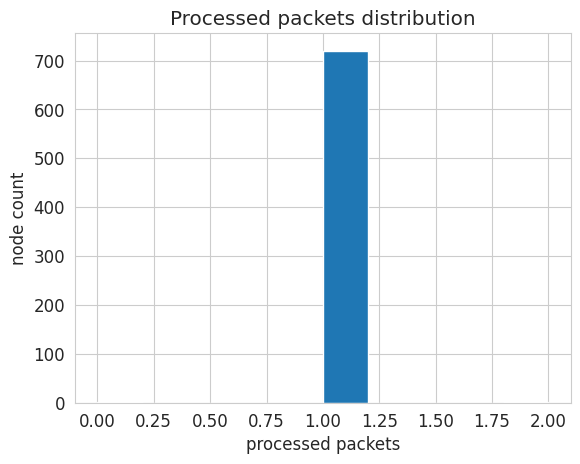

In [58]:
print(df_stats["latency_distribution"].describe())
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [59]:
np.where(received_packets_hist > 1)

(array([0]),)

## Evaluation

In [60]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_rc', 'nemo_dc']

color_list = sns.color_palette(n_colors=7)
colors = np.asarray(color_list.as_hex())

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6]
}

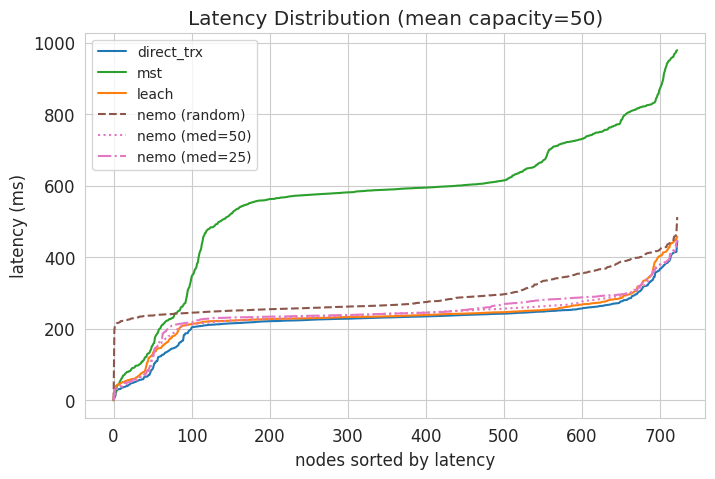

Means:  {'dt': 225.7, 'mst': 568.15, 'leach': 235.8, 'chain': 8520.43, 'nemo (random)': 291.48, 'nemo (med=50)': 238.22, 'nemo (med=25)': 244.56}
Quantiles:  {'dt': 276.26, 'mst': 781.92, 'leach': 286.08, 'chain': 16422.76, 'nemo (random)': 387.45, 'nemo (med=50)': 292.75, 'nemo (med=25)': 296.03}


In [61]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    elif l == "chain":
        continue
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for l in heterogen_appr:
    if l in ["nemo_dc", "nemo_rc"]:
        cl = l
        emat = eval_matrix[l]
        #print("Mean latency ", l, ": ", round(emat["capacity_50"]["latency_distribution"].mean(), 2))

        if l == "nemo_dc":
            l = "nemo"
        elif l == "nemo_rc":
            l = "nemo (random)"

        i = 0
        for k, df in emat.items():
            if l != "nemo" and k != "base":
                continue
            #if i % 50 == 0:
            if l=="nemo" and k == "base":
                continue
                sv = df["latency_distribution"].sort_values()
                sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "base":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l] = round(sv.quantile(0.9), 2)
                mean_dict[l] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "capacity_100":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ first_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ first_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l+" (med="+ first_med_label + ")", color=eval_colors[cl], linestyle=":")
            elif k == "capacity_1":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ last_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ last_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label= l+" (med="+ last_med_label + ")", color=eval_colors[cl], linestyle="-.")
            i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
#plt.ylim([0, 150])
plt.savefig("plots/atlas/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()

print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [62]:
load_dict = {}
nn_dict = {}
for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in capacity_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in capacity_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = capacity_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat["base"]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k + "_base"] = capacity_list
        nn_dict[k + "_base"] = nn_list
load_dict.keys()
agg_arr1 = []
for fam in heterogen_appr:
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
mr = np.mean(np.array(agg_arr1), axis=0)
load_dict["NEMO+redistribution"] = mr
print(mr)

agg_arr2 = []
for fam in heterogen_appr:
    agg_arr2.append(load_dict[fam + "_base"])
mr = np.mean(np.array(agg_arr2), axis=0)
load_dict["NEMO_base"] = mr
print(mr)

Fam:  nemo_rc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3.  3.  3.5 3.5 3.  3.5 3.  3.5 4.5 3.  4.  4.5]


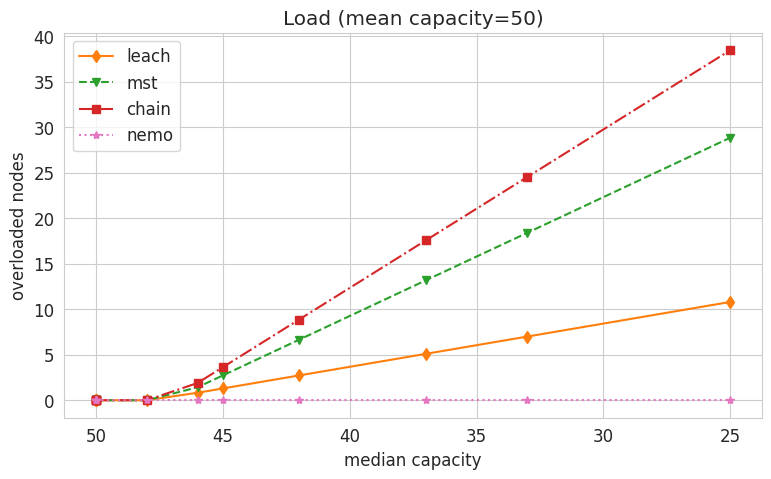

In [63]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution", "NEMO_base"]:
    vals = load_dict[fam]
    evcol = fam
    m, b = np.polyfit(medians, vals, 1)
    if fam == "sbon":
        fam = "sbon+NEMO_grouping"
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "NEMO+redistribution":
        fam = "nemo"
    if fam == "NEMO_base":
        fam = "nemo (base)"
        continue
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")

#ax.set_yscale('log')
ax.legend()
plt.savefig("plots/atlas/eval_load.svg")

ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()